In [1]:
import cv2
import numpy as np
from skimage.feature import graycomatrix, graycoprops
import os
import matplotlib.pyplot as plt

In [2]:
def downsample_image(image_path, scale_percent):
    image = cv2.imread(image_path)
    width = int(image.shape[1] * scale_percent / 100)
    height = int(image.shape[0] * scale_percent / 100)
    new_dim = (width, height)
    resized_image = cv2.resize(image, new_dim, interpolation=cv2.INTER_LINEAR)
    
    return resized_image

# Criteria

## Color Complextiy

In [3]:
# How many types of colors are used
def count_unique_colors(image_path):
    image = cv2.imread(image_path)
    image = downsample_image(image_path, 0.75)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)  

    image = image // 40 * 40  
    unique_colors = np.unique(image.reshape(-1, image.shape[2]), axis=0)
    
    return len(unique_colors)

# Degree of color gradient and contrast
def calculate_color_entropy(image_path):
    image = cv2.imread(image_path)
    image = downsample_image(image_path, 0.75)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    
    hist = cv2.calcHist([image], [0, 1, 2], None, [256, 256, 256], [0, 256, 0, 256, 0, 256])
    hist_norm = hist / hist.sum()
    entropy = -np.sum(hist_norm[hist_norm>0] * np.log2(hist_norm[hist_norm>0]))
    
    return entropy

## Textures and details

In [4]:
# Types and complexity of textures in images
def texture_analysis(image_path):
    image = cv2.imread(image_path)
    image = downsample_image(image_path, 0.75)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    glcm = graycomatrix(image, [1], [0, np.pi/4, np.pi/2, 3*np.pi/4], 256, symmetric=True, normed=True)
    contrast = graycoprops(glcm, 'contrast')
    homogeneity = graycoprops(glcm, 'homogeneity')
    
    return contrast, homogeneity

# Richness of image detail
def edge_density(image_path):
    image = cv2.imread(image_path)
    image = downsample_image(image_path, 0.75)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    edges = cv2.Sobel(image, cv2.CV_64F, 1, 1, ksize=5)
    density = np.mean(edges)
    
    return density


In [5]:
image_dir = 'dataset/'
image_paths = [image_dir + f for r,d,fs in os.walk(image_dir) for f in fs if f.endswith('.JPG') or f.endswith('.jpg')]

In [6]:
for p in image_paths:
    print(p.split('/')[-1])
    num_colors = count_unique_colors(p)
    entropy = calculate_color_entropy(p)
    contrast, homogeneity = texture_analysis(p)
    density = edge_density(p)
    
    print(f'\tNumber of colors: {num_colors}')
    print(f'\tentropy: {entropy}')
    # print(f'\tcontrast: {contrast}')
    print(f'\thomogeneity: {homogeneity}')
    # print(f'\tedge density: {density}')
    print()

torii.jpg
	Number of colors: 19
	entropy: 8.910001754760742
	homogeneity: [[0.05086428 0.03928212 0.03672597 0.03194073]]
summer.jpg
	Number of colors: 15
	entropy: 8.955928802490234
	homogeneity: [[0.0565067  0.05362258 0.0634443  0.05474027]]
machine.jpg
	Number of colors: 12
	entropy: 8.506053924560547
	homogeneity: [[0.2541737  0.05659442 0.06483828 0.07774614]]
train.jpg
	Number of colors: 17
	entropy: 8.85882568359375
	homogeneity: [[0.09969747 0.05013823 0.05167349 0.04307823]]
atomic-dome.jpg
	Number of colors: 23
	entropy: 8.966901779174805
	homogeneity: [[0.03489026 0.02656895 0.03773701 0.02366165]]
park.JPG
	Number of colors: 19
	entropy: 9.944619178771973
	homogeneity: [[0.06833862 0.04441856 0.04870397 0.04553549]]
gardenCat.JPG
	Number of colors: 20
	entropy: 8.33407211303711
	homogeneity: [[0.16079529 0.04499433 0.05611211 0.0560016 ]]
summer2.jpg
	Number of colors: 30
	entropy: 9.868631362915039
	homogeneity: [[0.05699238 0.04048656 0.04985441 0.04042849]]
city.jpg
	Nu

# Evaluation(distortion)

In [7]:
def cal_distortion(depth_dir, cut_dir, cut_file_name):

    depth = np.load(depth_dir+cut_file_name+'.npy')[0, :, :]
    layers_files = [r+'/'+f for r, d, fs in os.walk(cut_dir+cut_file_name) for f in fs if f.endswith('l.npy')]
    depth_step = 60/(len(layers_files)-1)
    cut_depth = [i*depth_step for i in range(len(layers_files))]
    layer_masks = [np.load(f) for f in layers_files]

    distortion = 0
    for i, mask in enumerate(layer_masks):
        distortion += np.sum(depth[mask] - cut_depth[i])
        # distortion += np.mean(depth[mask] - np.sum(depth[mask])/np.sum(mask))

    return distortion/(depth.shape[0] * depth.shape[1])

In [8]:
depth_dir = './dataset/depth/'
depth_paths = [ f for r, d, fs in os.walk(depth_dir) for f in fs]
cut_dir = './output-sam/'
cut_file_names = [ d for r, ds, fs in os.walk(cut_dir) for d in ds]

In [9]:
for cut_name in cut_file_names:
    print(cut_name, cal_distortion(depth_dir, cut_dir, cut_name))

gardenCat -16.4725888424868
torri 5.208821182035468
snowmountain2 -8.805611813982349
lake -19.28191899648373
snowmountain -18.751644250847058
summer -5.500577688077688
spring -23.654746720116616


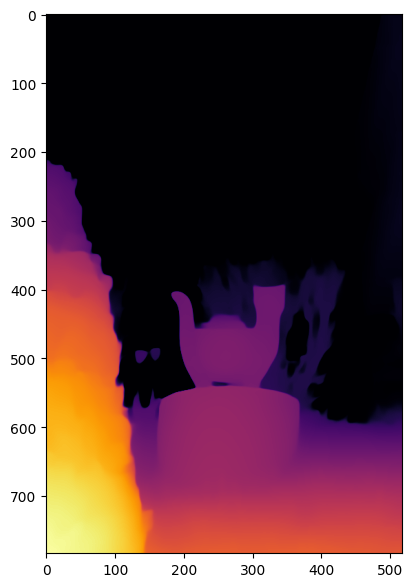

In [10]:
plt.figure(figsize=(15,7))
plt.imshow(np.load(depth_dir+'gardenCat.npy')[0,:,:],cmap='inferno')
plt.show()

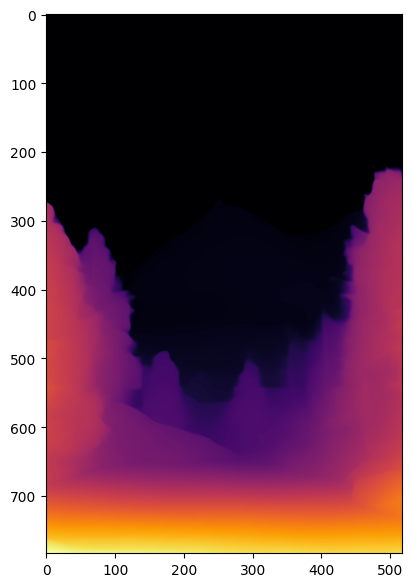

In [11]:
plt.figure(figsize=(15,7))
plt.imshow(np.load(depth_dir+'snowmountain.npy')[0,:,:],cmap='inferno')
plt.show()

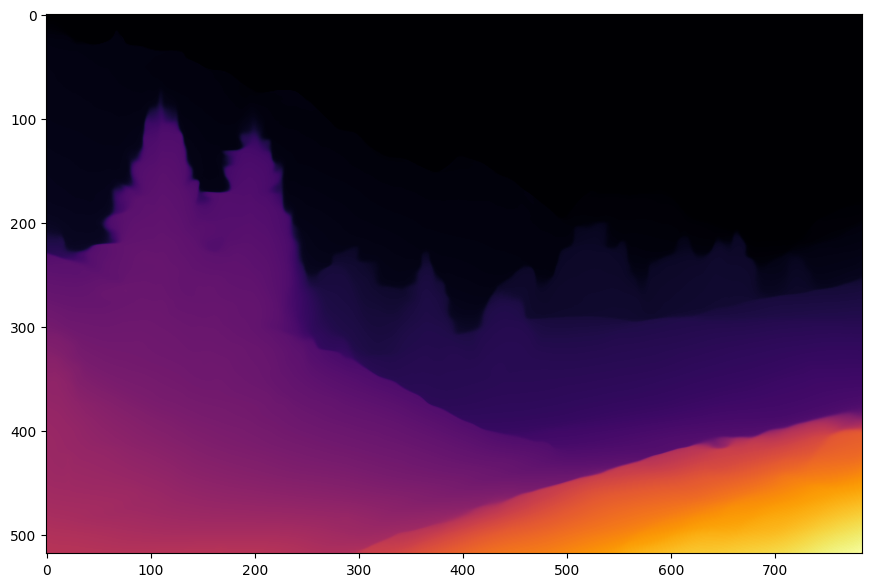

In [12]:
plt.figure(figsize=(15,7))
plt.imshow(np.load(depth_dir+'snowmountain2.npy')[0,:,:],cmap='inferno')
plt.show()

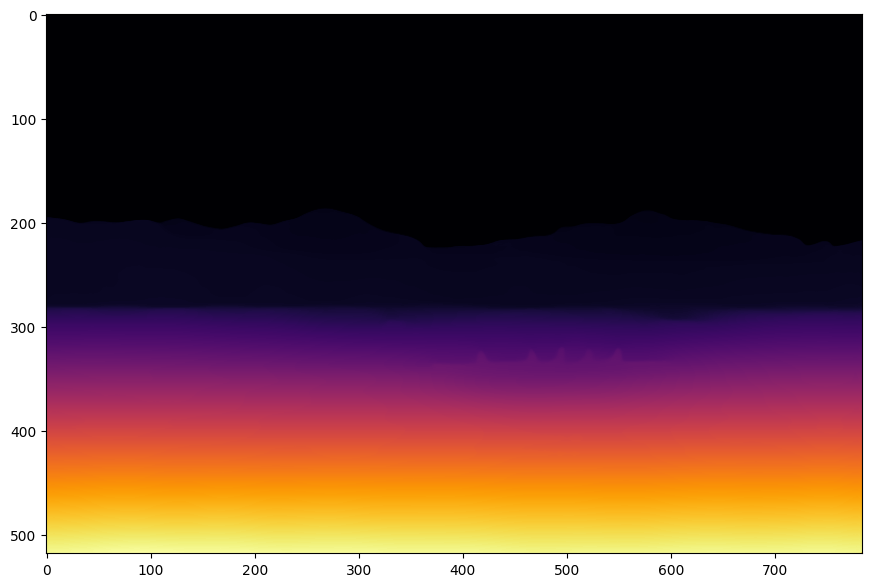

In [13]:
plt.figure(figsize=(15,7))
plt.imshow(np.load(depth_dir+'lake.npy')[0,:,:],cmap='inferno')
plt.show()